<a href="https://colab.research.google.com/github/vzeizer/Sales_ML_Forecasting/blob/master/MotoBombas_Modelagem_CodigoProduto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sistema de Previsão de Demanda para Motobombas utilizando Machine Learning**

**Contexto do Negócio:**
Uma empresa fabricante de motobombas necessita otimizar seu planejamento de produção através de previsões de demanda mais acuradas. O atual processo de previsão, baseado em médias históricas simples, resulta em erros significativos que impactam toda a cadeia produtiva.

**Problema de Negócio:**
A empresa precisa de um sistema de previsão de demanda mais preciso que possa:
1. Prever vendas com diferentes horizontes temporais (1 semana, 2 semanas, 1 mês)
2. Considerar padrões sazonais e tendências
3. Dar suporte ao planejamento de produção e estoque
4. Reduzir custos operacionais através de melhor planejamento

**Abordagem de Modelagem:**

1. **Feature Engineering:**
   - Criação de lags de 1 a 12 períodos anteriores
   - Médias móveis de 3, 6 e 12 períodos
   - Desvio padrão móvel
   - Features de sazonalidade (mês, semana do ano)
   - Tendência temporal
   - Rolling statistics (min, max, mediana)

2. **Horizontes de Previsão:**
   - Curto prazo: 1 semana à frente
   - Médio prazo: 2 semanas à frente
   - Longo prazo: 1 mês à frente

3. **Modelos a serem testados:**
   - SARIMA
   - XGBoost
   - LightGBM
   - LSTM
   - Ensemble methods

4. **Metodologia:**
   - Cross-validation temporal
   - Backtesting com diferentes janelas
   - Validação em múltiplos horizontes
   - Fine-tuning de hiperparâmetros
   - Análise de importância de features

**Métricas de Avaliação:**
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- RMSE (Root Mean Square Error)
- R² para diferentes horizontes temporais

**Objetivos do Projeto:**
1. Desenvolver modelo com MAPE < 15% para previsão semanal
2. Desenvolver modelo com MAPE < 20% para previsão quinzenal
3. Desenvolver modelo com MAPE < 25% para previsão mensal
4. Criar sistema de atualização automática do modelo
5. Implementar alertas de desvio significativo

**Entregáveis:**
1. Notebooks com todo processo de modelagem
2. API para servir as previsões
3. Dashboard de monitoramento do modelo
4. Documentação técnica completa
5. Análise de importância das features

**Impacto Esperado:**
- Redução de 30% no erro de previsão
- Redução de 25% nos custos de estoque
- Aumento de 20% na eficiência da produção
- ROI esperado de 300% no primeiro ano

**Pipeline de Modelagem:**
1. **Preparação dos Dados:**
   - Tratamento de outliers
   - Normalização/Padronização
   - Criação de features temporais
   - Encoding de variáveis categóricas

2. **Experimentação:**
   - Teste de diferentes arquiteturas
   - Validação cruzada temporal
   - Análise de erros
   - Seleção de features

3. **Produção:**
   - Versionamento do modelo
   - Monitoramento de performance
   - Sistema de retraining
   - Validação contínua

Este problema é interessante porque:
- Demonstra habilidades em séries temporais
- Trabalha com diferentes horizontes de previsão
- Usa técnicas avançadas de feature engineering
- Possui aplicação prática e mensurável
- Permite comparação de diferentes algoritmos

In [129]:
# installing specific libraries
#!pip install scikit-learn==1.6.1 xgboost==1.7.3 pandas==2.2.2
#!pip install scikit-learn==1.2.2 xgboost==1.7.6 pandas==2.2.2
!pip install scikit-learn==1.2.2 xgboost==1.7.6 pandas==2.2.2 numpy==1.24.4



In [130]:
# imports para cálculos numéricos
import pandas as pd
import numpy as np

# imports estatísticos
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# imports para visualizações
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Machine Learning Modeling

In [131]:
# lendo o arquivo
df = pd.read_excel('/content/Lucas - Relatório saida motobombas 2018 2024 - 26.02.xls')
# size of the training set

TRAIN_SIZE = 0.833
# NÚMEROS DE LAGS
lagini = 15
# dias para reamostragem na modelagem
RESAMPLE_DAYS = 30
# semana, quinzena, mes para prever com antecencia com respeito a RESAMPLE_DAYS acima
ADVANCE_RESAMPLE_DAYS = 0

In [132]:
# visualizando as primeiras linhas
df.head(10)

,Dt. emissão,Cód. produto,Grupo de produto,Produto,Qt. item,Vl. faturamento,Tipo de movimento da operação
0,04/12/2018,1.140000e+02,MOTOBOMBA APL ...,MOTOBOMBA C/PREFILTRO 1.5 HP TRI.220/380V.MOD....,1,1582.00,Venda
1,14/12/2018,9.375000e+03,MOTOBOMBAS POOLTEC ...,POOLTEC MOTOBOMBA BN-2 1/2 CV TRIF ...,1,600.00,Venda
2,09/01/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2,2481.88,Venda
3,19/01/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2,2351.25,Venda
4,07/03/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1,1237.50,Venda
5,26/03/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1,1278.75,Venda
6,02/04/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1,1113.75,Venda
7,16/04/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1,1200.38,Venda
8,25/04/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1,1175.63,Venda
9,26/04/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,3,3650.63,Venda


In [133]:
# Nome dos atributos
print(list(df.columns))

['Dt. emissão', 'Cód. produto', 'Grupo de produto', 'Produto', 'Qt. item', 'Vl. faturamento', 'Tipo de movimento da operação']


In [134]:
# renomeando os atributos
df = df.rename(columns={'Dt. emissão':'data', 'Cód. produto':'cod_produto', 'Grupo de produto':'grupo_produto', 'Produto':'produto',
       'Qt. item':'qt_item', 'Vl. faturamento':'valor', 'Tipo de movimento da operação':'tipo_operacao'})

In [135]:
# averiguando atributos nulos
df.isnull().sum()

,0
data,1
cod_produto,1
grupo_produto,1
produto,1
qt_item,0
valor,0
tipo_operacao,1


In [136]:
# eliminando linhas com valores nulos
df = df.dropna()

In [137]:
# dimensões do DataFrame
df.shape

(11015, 7)

In [138]:
# venda o percentual de Vendas e Devoluções
100*df['tipo_operacao'].value_counts(normalize=True)

,proportion
tipo_operacao,
Venda,98.992283
Devolução,1.007717


In [139]:
# 1% é devolução. Vamos retirar isso
df = df[df['tipo_operacao'].isin(['Venda'])]

In [140]:
# verificando, novamente, as dimensões do DataFrame
df.shape

(10904, 7)

In [141]:
# olhando as cinco primeiras linhas
df.head(5)

,data,cod_produto,grupo_produto,produto,qt_item,valor,tipo_operacao
0,04/12/2018,1.140000e+02,MOTOBOMBA APL ...,MOTOBOMBA C/PREFILTRO 1.5 HP TRI.220/380V.MOD....,1,1582.00,Venda
1,14/12/2018,9.375000e+03,MOTOBOMBAS POOLTEC ...,POOLTEC MOTOBOMBA BN-2 1/2 CV TRIF ...,1,600.00,Venda
2,09/01/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2,2481.88,Venda
3,19/01/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2,2351.25,Venda
4,07/03/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1,1237.50,Venda


Averiguando se o conjunto de dados é estacionário ou não estacionário usando o método Dicky Fuller aumentado.

**Se o valor-p > 0,05, então determinada coluna é não estacionária, caso contrário, é estacionária.**

- **Estacionário**: Se os dados contiverem média e variância quase constantes.
- **Não estacionário**: Média e variância não são constantes ao longo do tempo.

In [142]:
# aplicando teste de estacionariedade
# comentado por ser demorado
#col = 'qt_item'
#print(f"Valor-p da Coluna para teste de estacionariedade {col}': {adfuller(df.sort_values(by=['cod_produto','data'])[col])[1]}")

In [143]:
# dropando valor e tipo de operacao
df = df.drop(columns=['valor','tipo_operacao'])

In [144]:
# olhando os 5 primeiros registros de df
df.head(5)

,data,cod_produto,grupo_produto,produto,qt_item
0,04/12/2018,1.140000e+02,MOTOBOMBA APL ...,MOTOBOMBA C/PREFILTRO 1.5 HP TRI.220/380V.MOD....,1
1,14/12/2018,9.375000e+03,MOTOBOMBAS POOLTEC ...,POOLTEC MOTOBOMBA BN-2 1/2 CV TRIF ...,1
2,09/01/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2
3,19/01/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2
4,07/03/2018,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1


In [145]:
# número de códigos de produtos únicos
df['cod_produto'].nunique()

67

In [146]:
# número de códigos de grupos únicos
df['grupo_produto'].nunique()

7

In [147]:
# número de produtos únicos
df['produto'].nunique()
# confere com 'cod_produto'
# cod_produto e produto são redundantes

67

In [148]:
# lidando com a parte temporal
# lidando com o formato da data
df['data'] = pd.to_datetime(df['data'],dayfirst=True)

In [149]:
# Extract year, month, day, day of week, etc.
df['year'] = df['data'].dt.year
df['month'] = df['data'].dt.month
df['day'] = df['data'].dt.day
df['dayofweek'] = df['data'].dt.dayofweek  # Monday = 0, Sunday = 6
df['is_weekend'] = df['dayofweek'].isin([5, 6])  # Boolean for weekend days

# More advanced features (consider based on your needs)
df['week_of_year'] = df['data'].dt.isocalendar().week
df['quarter'] = df['data'].dt.quarter

In [150]:
# olhando os 5 primeiros registros
df.head(5)

,data,cod_produto,grupo_produto,produto,qt_item,year,month,day,dayofweek,is_weekend,week_of_year,quarter
0,2018-12-04,1.140000e+02,MOTOBOMBA APL ...,MOTOBOMBA C/PREFILTRO 1.5 HP TRI.220/380V.MOD....,1,2018,12,4,1,False,49,4
1,2018-12-14,9.375000e+03,MOTOBOMBAS POOLTEC ...,POOLTEC MOTOBOMBA BN-2 1/2 CV TRIF ...,1,2018,12,14,4,False,50,4
2,2018-01-09,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2,2018,1,9,1,False,2,1
3,2018-01-19,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2,2018,1,19,4,False,3,1
4,2018-03-07,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,1,2018,3,7,2,False,10,1


In [151]:
# ordenando por código de produto e data
df = df.sort_values(by=['grupo_produto','data'])

In [152]:
# olhando os 10 primeiros registros
df.head(10)

,data,cod_produto,grupo_produto,produto,qt_item,year,month,day,dayofweek,is_weekend,week_of_year,quarter
1120,2018-01-09,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-4 - 1 HP MONOF. 60H...,3,2018,1,9,1,False,2,1
913,2018-01-10,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-3 - 3/4 HP MONOF. 6...,9,2018,1,10,2,False,2,1
695,2018-01-12,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-2 - 1/2 HP MONO 60H...,1,2018,1,12,4,False,2,1
696,2018-01-16,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-2 - 1/2 HP MONO 60H...,3,2018,1,16,1,False,3,1
1121,2018-01-17,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-4 - 1 HP MONOF. 60H...,1,2018,1,17,2,False,3,1
914,2018-01-23,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-3 - 3/4 HP MONOF. 6...,2,2018,1,23,1,False,4,1
1122,2018-01-23,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-4 - 1 HP MONOF. 60H...,2,2018,1,23,1,False,4,1
697,2018-01-25,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-2 - 1/2 HP MONO 60H...,1,2018,1,25,3,False,4,1
1123,2018-01-30,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-4 - 1 HP MONOF. 60H...,1,2018,1,30,1,False,5,1
1124,2018-01-31,7.890037e+12,MOTOBOMBA AD ...,MOTOBOMBA AUTO-DRENANTE AD-4 - 1 HP MONOF. 60H...,2,2018,1,31,2,False,5,1


### Filling gaps in the Data

In [153]:
# vamos preencher o dataframe colocando as datas onde não houveram vendas
cod_prods = df['cod_produto'].unique()

df_prods_final = []

for prod in cod_prods:
  # Define the desired date range (assuming 'data' is the date column)
  df_prod = df[df['cod_produto']==prod]
  desired_date_range = pd.date_range(start=df_prod['data'].min(), end=df_prod['data'].max())

  df_aux = pd.DataFrame(index=desired_date_range,columns=['qt_item'])
  df_aux = df_aux.reset_index().rename(columns={'index':'data'})
  df_aux['qt_item'] = 0
  df_aux['data'] = pd.to_datetime(df_aux['data'])
  df_prod = pd.merge(df_prod, df_aux, on='data', how='right').sort_values(by='data')
  df_prod['qt_item'] = df_prod['qt_item_x'].fillna(0) + df_prod['qt_item_y']
  df_prod = df_prod.drop(columns=['qt_item_x','qt_item_y'])
  df_prod = df_prod.interpolate(method='ffill')
  df_prods_final.append(df_prod)

In [154]:
# concat todos os conjunto de dados
df_prods_final = pd.concat(df_prods_final).sort_values(by=['cod_produto','data'])

In [155]:
df_prods_final.head(5)

,data,cod_produto,grupo_produto,produto,year,month,day,dayofweek,is_weekend,week_of_year,quarter,qt_item
0,2018-12-04,1.140000e+02,MOTOBOMBA APL ...,MOTOBOMBA C/PREFILTRO 1.5 HP TRI.220/380V.MOD....,2018.0,12.0,4.0,1.0,False,49,4.0,1.0
0,2018-12-14,9.375000e+03,MOTOBOMBAS POOLTEC ...,POOLTEC MOTOBOMBA BN-2 1/2 CV TRIF ...,2018.0,12.0,14.0,4.0,False,50,4.0,1.0
0,2018-01-09,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2018.0,1.0,9.0,1.0,False,2,1.0,2.0
1,2018-01-10,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2018.0,1.0,9.0,1.0,False,2,1.0,0.0
2,2018-01-11,7.890037e+12,MOTOBOMBA AP,MOTOBOMBA AP-6 2 CV 127/220V (47 x 39 x 61 cm)...,2018.0,1.0,9.0,1.0,False,2,1.0,0.0


In [156]:
df_prods_final['grupo_produto'].unique()

array(['MOTOBOMBA APL                                     ',
       'MOTOBOMBAS POOLTEC                                ',
       'MOTOBOMBA AP',
       'MOTOBOMBA AD                                      ',
       'MOTOBOMBA APH                                     ',
       'MOTOBOMBA APP',
       'MOTOBOMBA AHP                                     '], dtype=object)

In [157]:
# dimensões do DataFrame
df_prods_final.shape

(102480, 12)

<Axes: xlabel='qt_item', ylabel='Count'>

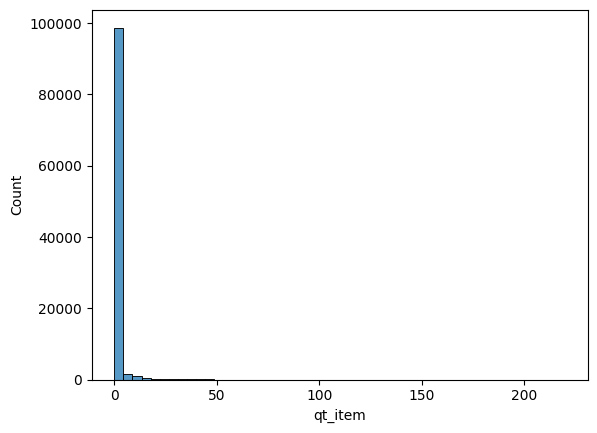

In [158]:
# inspeção básica de dados -> muitos dias sem vendas, o que indica que uma reamostragem é essencial!
sns.histplot(data=df_prods_final,x='qt_item',bins=50)

In [159]:
# vendo a quantidade de itens em formato de proporção
df_prods_final['qt_item'].value_counts(normalize=True)

,proportion
qt_item,
0.0,0.893599
1.0,0.035207
2.0,0.019506
3.0,0.008880
4.0,0.006343
...,...
118.0,0.000010
93.0,0.000010
111.0,0.000010


In [160]:
# visualizando as estatísticas descritivas do dataset
df_prods_final.describe()

,data,cod_produto,year,month,day,dayofweek,week_of_year,quarter,qt_item
count,102480,1.024800e+05,102480.000000,102480.000000,102480.000000,102480.000000,102480.0,102480.000000,102480.000000
mean,2021-01-17 14:03:28.243559680,7.889883e+12,2020.357455,6.427313,16.196351,2.437890,26.27098,2.471526,0.643140
min,2018-01-02 00:00:00,1.140000e+02,2018.000000,1.000000,1.000000,0.000000,1.0,1.000000,0.000000
25%,2019-08-10 00:00:00,7.890037e+12,2019.000000,3.000000,10.000000,1.000000,12.0,1.000000,0.000000
50%,2020-12-26 00:00:00,7.890037e+12,2020.000000,6.000000,16.000000,3.000000,26.0,2.000000,0.000000
75%,2022-07-08 00:00:00,7.890037e+12,2022.000000,10.000000,23.000000,4.000000,40.0,4.000000,0.000000
max,2024-02-26 00:00:00,7.890037e+12,2024.000000,12.000000,31.000000,4.000000,53.0,4.000000,220.000000
std,NaN,3.485558e+10,1.708798,3.474863,8.388554,1.354981,15.194213,1.145317,3.728135


In [161]:
# aplicando teste de estacionariedade, novamente
# Comentado por ser muito demorado rodar o teste.
#col = 'qt_item'
#print(f"Valor-p da Coluna para teste de estacionariedade {col}': {adfuller(df_prods_final[col])[1]}")

### Statistical Analysis

In [162]:
# vamos começar com decomposição multiplicativa da série temporal
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposição Multiplicativa
decomposicao_aditiva = sm.tsa.seasonal_decompose(df_prods_final['qt_item'],
                                                        model = 'additive',
                                                        period=7)

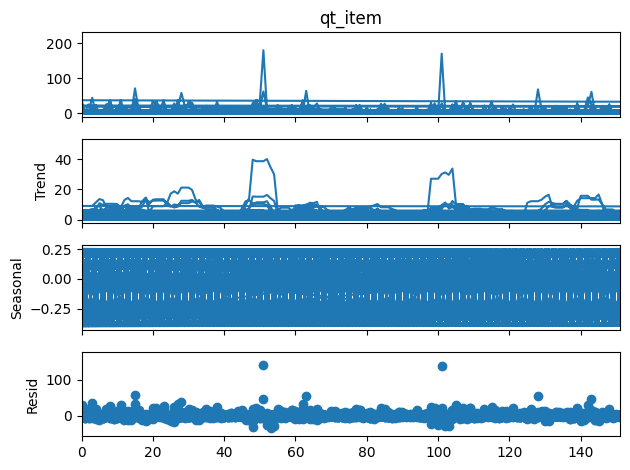

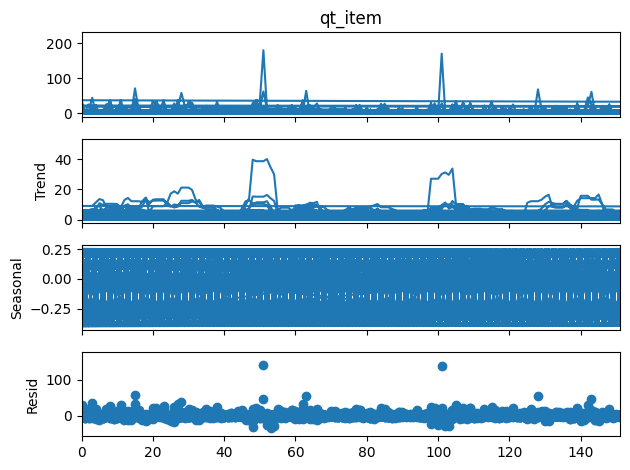

In [163]:
# fazendo um gráfico
decomposicao_aditiva.plot()

In [164]:
# fazendo uma cópia desse dataframe para fazer ML posteriormente
df_prods_final_ML = df_prods_final.copy()

In [165]:
# vamos escolher o grupo de produto com mais vendas e modelar com ARIMA
prod_escolhido = df_prods_final['grupo_produto'].value_counts().index[0]
df_prods_final = df_prods_final[df_prods_final['grupo_produto']==prod_escolhido]

In [166]:
from statsmodels.tsa.arima.model import ARIMA

# Set the time series data as the index
df_prods_final = df_prods_final.set_index(['data'])

# Define the ARIMA model order (p, d, q) based on analysis (e.g., ACF/PACF plots)
#model = ARIMA(df_prods_final.groupby(by=['cod_produto'],as_index=False)['qt_item'].resample('15D').sum()
model = ARIMA(df_prods_final['qt_item'].resample('15D').sum()
, order=(2, 2, 2))  # Adjust p, d, q as needed

# Fit the model
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Define the number of periods to predict
n_periods = 3  # You can adjust this value

# Predict future values
predicted_values = model_fit.forecast(steps=n_periods)

# Create a DataFrame for predicted values (optional)
predicted_df = pd.DataFrame(predicted_values, index=df_prods_final.index[-n_periods:])
predicted_df.columns = ['predicted_value']

# Print or plot predicted values
print(predicted_df)  # Or use plotting libraries like matplotlib

                               SARIMAX Results                                
Dep. Variable:                qt_item   No. Observations:                  150
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -990.445
Date:                Mon, 19 May 2025   AIC                           1990.890
Time:                        21:05:20   BIC                           2005.876
Sample:                    01-02-2018   HQIC                          1996.979
                         - 02-15-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2661      0.136     -1.954      0.051      -0.533       0.001
ar.L2         -0.1712      0.110     -1.563      0.118      -0.386       0.044
ma.L1         -1.5325      0.138    -11.136      0.0

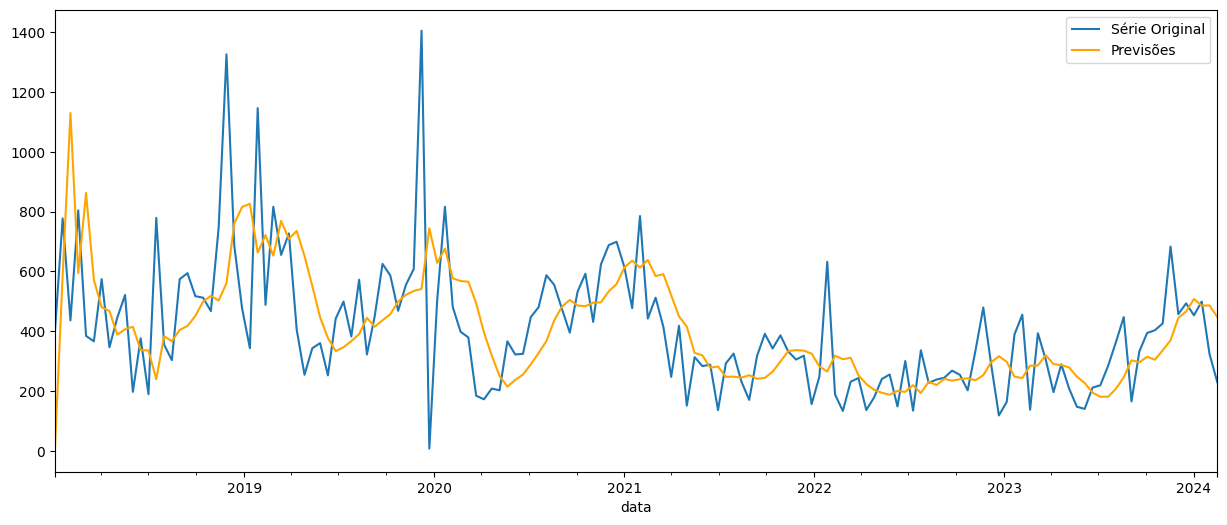

In [167]:
# Dados Reais e Previsões (em treino)
dados_reais = df_prods_final
previsoes_v3 = model_fit.fittedvalues

# Plot
plt.figure(figsize = (15, 6))
df_prods_final['qt_item'].resample('15D').sum().plot(label = 'Série Original')
previsoes_v3.plot(color = 'orange', label = 'Previsões')
plt.legend(loc = 'best')
plt.show()

In [168]:
# analisando os dados reamostrados de 15 dias
df_vendas = df_prods_final.resample('15D').sum()

In [169]:
#verificando a estacionariedade de alguns atributos
adfuller(df_vendas['qt_item'].diff().dropna())
adfuller(df_vendas['month'].diff().dropna())
adfuller(df_vendas['week_of_year'].diff().dropna())
adfuller(df_vendas['quarter'].diff().dropna())
adfuller(df_vendas['month'].diff().dropna())

(-7.598724724973401,
 2.4211362872818856e-11,
 1,
 147,
 {'1%': -3.4756368462466662,
  '5%': -2.8814104466172608,
  '10%': -2.5773652982553568},
 1973.12562602452)

<Figure size 1200x800 with 0 Axes>

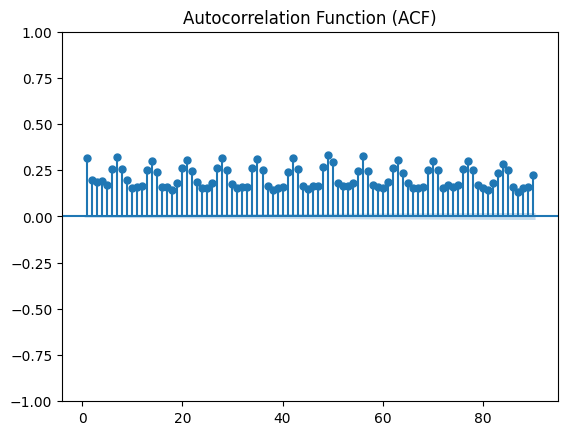

<Figure size 1200x800 with 0 Axes>

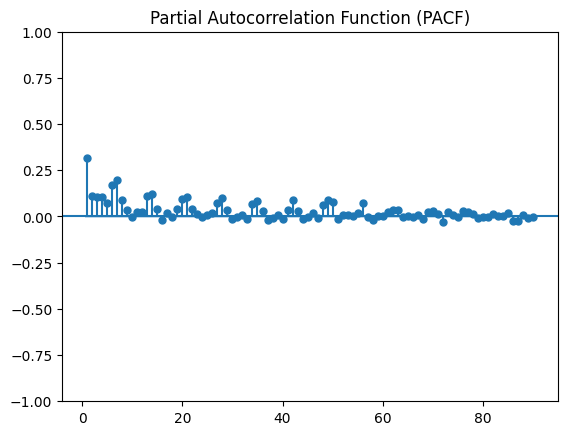

In [170]:
# agora, vamos fazer alguns gráficos para ter insights sobre os "lags" do target
# e sim, o PACF mostra que eles são muito importantes para a modelagem
series = df_prods_final_ML['qt_item']

lags = 90

# Plot ACF
plt.figure(figsize=(12, 8))
plot_acf(series, lags=lags, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 8))
plot_pacf(series, lags=lags, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1200x800 with 0 Axes>

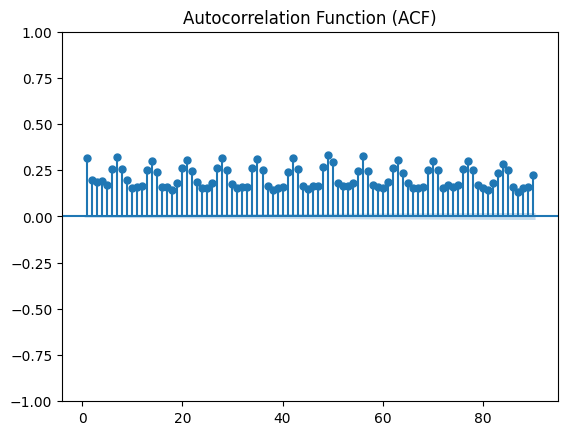

<Figure size 1200x800 with 0 Axes>

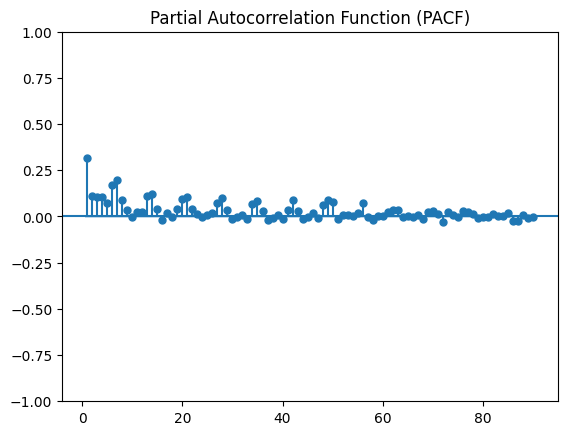

In [171]:
series = df_prods_final_ML['qt_item']

lags = 90

# Plot ACF
plt.figure(figsize=(12, 8))
plot_acf(series, lags=lags, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 8))
plot_pacf(series, lags=lags, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [172]:
# voltando ao dataset de ML
# verificando todos os tipos de produtos
df_prods_final_ML['grupo_produto'].unique()

array(['MOTOBOMBA APL                                     ',
       'MOTOBOMBAS POOLTEC                                ',
       'MOTOBOMBA AP',
       'MOTOBOMBA AD                                      ',
       'MOTOBOMBA APH                                     ',
       'MOTOBOMBA APP',
       'MOTOBOMBA AHP                                     '], dtype=object)

In [173]:
df_prods_final_ML.columns

Index(['data', 'cod_produto', 'grupo_produto', 'produto', 'year', 'month',
       'day', 'dayofweek', 'is_weekend', 'week_of_year', 'quarter', 'qt_item'],
      dtype='object')

### Time Series Machine Learning Modeling

In [174]:
monthly_sales = df_prods_final_ML.copy()
monthly_sales.set_index('data',inplace=True)
# ordenando e tirando features categóricos irrelevantes
monthly_sales = monthly_sales.drop(['cod_produto','produto'], axis = 1).sort_values(by=['grupo_produto','data'])
# OHE em grupo produto
monthly_sales = pd.get_dummies(monthly_sales, columns=['grupo_produto'])
monthly_sales.dropna(inplace=True)
if ADVANCE_RESAMPLE_DAYS > 0:
  monthly_sales['qt_item'] = monthly_sales['qt_item'].shift(-ADVANCE_RESAMPLE_DAYS)
  print('aq')
else:
  pass

In [175]:
#Aqui acontecem a criação dos lags de target
def create_lag_features(monthly_sales, lags=0,lagini=lagini):
  y = monthly_sales[['year', 'month','day', 'dayofweek',
                        'is_weekend', 'quarter', "qt_item"]]
  for col in list(y.columns):
    for lag in range(lagini, lags):
      monthly_sales[f"{col}_lag_{lag + 1}"] = y[col].shift(lag + 1)
  return monthly_sales

monthly_sales = create_lag_features(monthly_sales, lags=6,lagini=lagini)
monthly_sales = monthly_sales.dropna()

In [176]:
#Aqui acontecem a criação das médias movéis do lag1
def create_rolling_mean(monthly_sales, rolls=0,lagini=lagini):
  y = monthly_sales[['year', 'month','day', 'dayofweek',
                        'is_weekend', 'quarter', "qt_item"]].shift(lagini+1)
  for col in list(y.columns):
    for roll in range(1, rolls+1):
      monthly_sales[f"rolling_mean_{roll + 1}"] = y[col].rolling(window=roll+1).mean()
  return monthly_sales

monthly_sales = create_rolling_mean(monthly_sales, rolls=6,lagini=lagini)
monthly_sales = monthly_sales.fillna(0.0)

In [177]:
#Aqui acontecem a criação dos features de diff do lag1
def create_diff_features(monthly_sales, diffs=0,lagini=lagini):
  y = monthly_sales[['year', 'month','day', 'dayofweek',
                        'is_weekend', 'quarter', "qt_item"]].shift(1+lagini)
  for col in list(y.columns):
    for diff in range(diffs):
      monthly_sales[f"diff{diff + 1}"] = y[col].diff((diff) + 1)
  return monthly_sales

monthly_sales = create_diff_features(monthly_sales, diffs=5,lagini=lagini)
monthly_sales = monthly_sales.dropna()

In [178]:
# reamostrando pelo número de dias escolhido
monthly_sales = monthly_sales.resample(f'{RESAMPLE_DAYS}D').sum()

In [179]:
#Separação do conjunto entre treinamento e teste
train_size = int(len(monthly_sales) * TRAIN_SIZE)
train_data, test_data = monthly_sales[:train_size], monthly_sales[train_size:]

In [180]:
X_train = train_data.drop(columns=['qt_item'])
y_train = train_data["qt_item"]

X_test = test_data.drop(columns=['qt_item'])
y_test = test_data["qt_item"]

In [181]:
# feature que não serve pra nada, vamos retirar
X_train.drop(columns=['week_of_year'],inplace=True)
X_test.drop(columns=['week_of_year'],inplace=True)

In [182]:
# Aqui ocorre a aplicação do modelo XGBoost

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot

#Parâmetros abaixos definidos através de testes e leitura de material
#Melhores parâmetros até o momento: 13/05/2024 - 01:00am
cv_split = TimeSeriesSplit()
model = XGBRegressor(alpha=1, reg_lambda=1)
parameters = {
    "max_depth": [100], #Profundidade da árvore
    "learning_rate": [0.05,0.005,0.001], # Velocidade de aprendizagem
    "n_estimators": [50], # o número de execuções que o XGBoost tentará aprender
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

# Obtenha a melhor combinação de hiperparâmetros
xgb_best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", xgb_best_params)

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
# Treine o modelo novamente, porém agora com os melhores  hiperparâmetros
best_xgb_model = XGBRegressor(**xgb_best_params)
best_xgb_model.fit(X_train, y_train)

Melhores hiperparâmetros: {'learning_rate': 0.05, 'max_depth': 100, 'n_estimators': 50}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

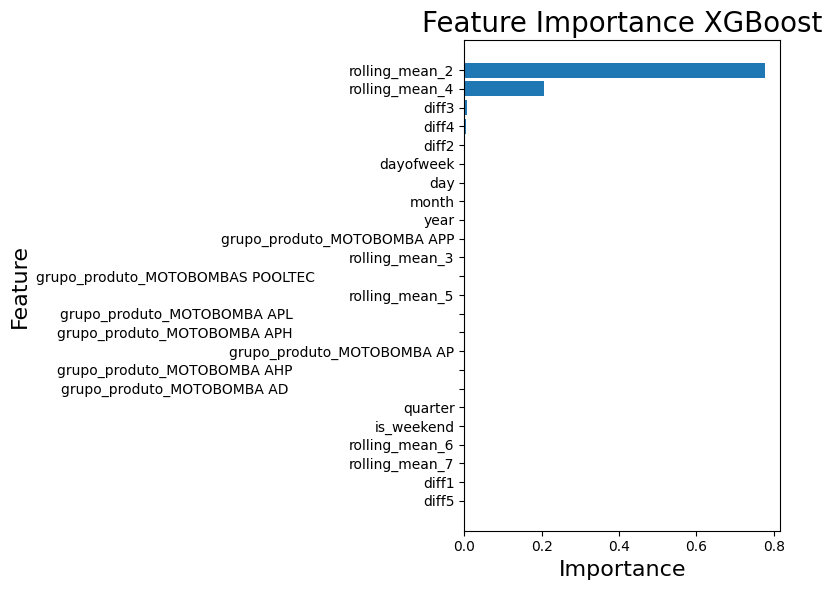

In [183]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, feature_names, model_name,title="Feature Importance", figsize=(8, 6)):
    """
    Create a horizontal bar plot of feature importance from a scikit-learn model.

    Parameters:
    -----------
    model : sklearn estimator
        Fitted model with feature_importances_ attribute (e.g., RandomForestClassifier)
    feature_names : list or array
        Names of the features
    title : str, optional
        Title of the plot
    figsize : tuple, optional
        Figure size (width, height)
    """
    # Get feature importances
    importances = model.feature_importances_

    # Sort features by importance
    indices = np.argsort(importances)

    # Create figure
    plt.figure(figsize=figsize)

    # Create horizontal bar plot
    y_pos = np.arange(len(feature_names))
    plt.barh(y_pos, importances[indices])

    # Customize plot
    plt.yticks(y_pos, np.array(feature_names)[indices])
    plt.xlabel('Importance',size=16)
    plt.ylabel('Feature',size=16)
    plt.title(title + " " + model_name,size=20)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return plt

feature_names = list(X_test.columns)  # Your feature names
plot_feature_importance(best_xgb_model, feature_names, model_name='XGBoost')
plt.show()

In [184]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn import metrics

In [185]:
def evaluate_model(y,prediction,conjunto):
  accuracy=100-(mean_absolute_percentage_error(y, prediction)*100)
  print(f'\nXGBOOST Acurácia Média {conjunto}: ', round(accuracy,2),'%.')
  print(f'XGBOOST Erro Médio Absoluto (MAE) {conjunto}: ', mean_absolute_error(y, prediction))
  print(f'XGBOOST Erro Quadrático Médio (MSE) {conjunto}: ', mean_squared_error(y, prediction))
  print(f'XGBOOST Raiz do Erro Quadrático Médio (RMSE) {conjunto}: ', mean_squared_error(y, prediction))
  print(f'XGBOOST Porcentagem do Erro Médio Absoluto (MAPE) {conjunto}: ',  round(mean_absolute_percentage_error(y, prediction)*100, 2),'%')
  #Proporção de variação dos dados explicados pelo modelo. Quanto mais perto de 1, melhor
  print(f'XGBOOST Explained Variance Score {conjunto}: ', metrics.explained_variance_score(y, prediction))
  #Maior erro entre previsões
  print(f'XGBOOST Erro Máximo {conjunto}: ', metrics.max_error(y, prediction))
  print(f'XGBOOST Erro Logarítmico Médio {conjunto}: ', metrics.mean_squared_log_error(y, prediction))
  #Mediana do erro entre valores previstos e valores reais
  print(f'XGBOOST Mediana do Erro Absoluto {conjunto}: ', metrics.median_absolute_error(y, prediction))

def plot_predictions(train_data, y, prediction):
  plt.figure(figsize=(10, 6))
  df_plot = pd.DataFrame({"data":train_data.reset_index(drop=False)['data'].values,"Predição":prediction,'Original':y})
  df_plot['Original'].plot(color = 'red', label = 'Original')
  df_plot['Predição'].plot(color = 'blue', label = 'Previsões')
  plt.legend(loc = 'best')
  plt.show()


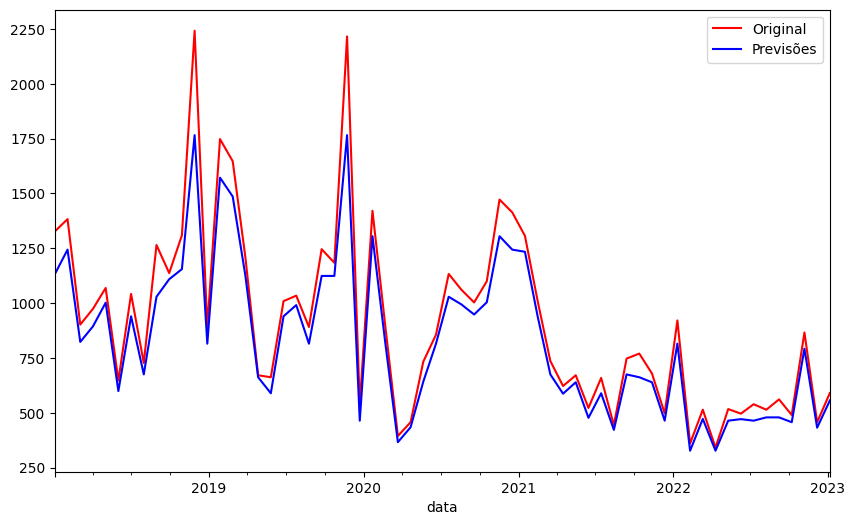


XGBOOST Acurácia Média Treino:  91.24 %.
XGBOOST Erro Médio Absoluto (MAE) Treino:  87.93548387096774
XGBOOST Erro Quadrático Médio (MSE) Treino:  14642.161290322581
XGBOOST Raiz do Erro Quadrático Médio (RMSE) Treino:  14642.161290322581
XGBOOST Porcentagem do Erro Médio Absoluto (MAPE) Treino:  8.76 %
XGBOOST Explained Variance Score Treino:  0.9598593361942841
XGBOOST Erro Máximo Treino:  476.0
XGBOOST Erro Logarítmico Médio Treino:  0.010436479592639537
XGBOOST Mediana do Erro Absoluto Treino:  71.0


In [186]:
# Validando os resultados
prediction_xgb_train = best_xgb_model.predict(X_train).round()
plot_predictions(X_train, y_train, prediction_xgb_train)
evaluate_model(y_train, prediction_xgb_train,'Treino')

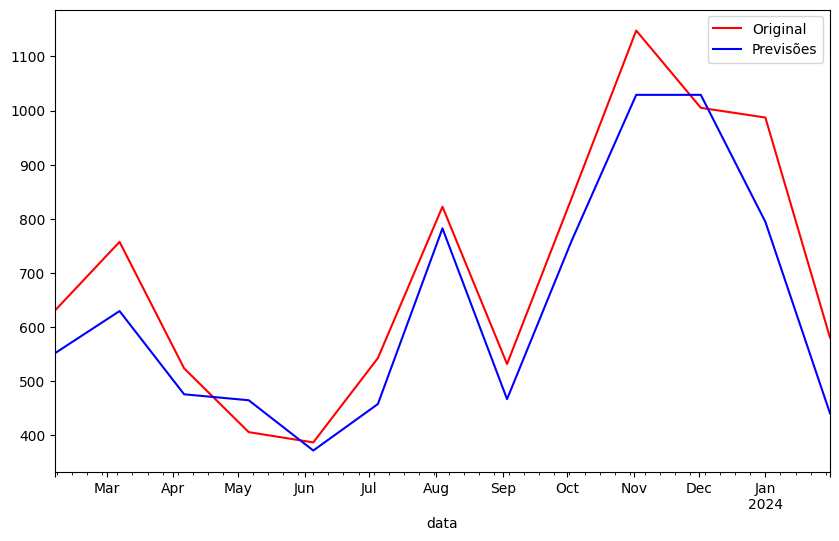


XGBOOST Acurácia Média Teste:  88.02 %.
XGBOOST Erro Médio Absoluto (MAE) Teste:  82.61538461538461
XGBOOST Erro Quadrático Médio (MSE) Teste:  9193.23076923077
XGBOOST Raiz do Erro Quadrático Médio (RMSE) Teste:  9193.23076923077
XGBOOST Porcentagem do Erro Médio Absoluto (MAPE) Teste:  11.98 %
XGBOOST Explained Variance Score Teste:  0.9201911755338396
XGBOOST Erro Máximo Teste:  193.0
XGBOOST Erro Logarítmico Médio Teste:  0.02117627984942633
XGBOOST Mediana do Erro Absoluto Teste:  79.0


In [187]:
# Validando os resultados
prediction_xgb_test = best_xgb_model.predict(X_test).round()
plot_predictions(X_test, y_test, prediction_xgb_test)
evaluate_model(y_test, prediction_xgb_test,'Teste')

In [188]:
# Modelo Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


print("Starting model train..")
# Number of trees in random forest
n_estimators_rf = [10,20,50]
# Maximum number of levels in tree
max_depth_rf = [10,50]
# Minimum number of samples required to split a node
min_samples_split_rf = [2, 4]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators_rf,
               'max_depth': max_depth_rf,
               'min_samples_split': min_samples_split_rf,
               'criterion' :[ 'absolute_error']
               }


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3,
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

# Treine o modelo novamente, porém agora com os melhores  hiperparâmetros
best_rf_random = RandomForestRegressor(**rf_random.best_params_)
best_rf_random.fit(X_train, y_train)

Starting model train..
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomForestRegressor(criterion='absolute_error', max_depth=10, n_estimators=10)

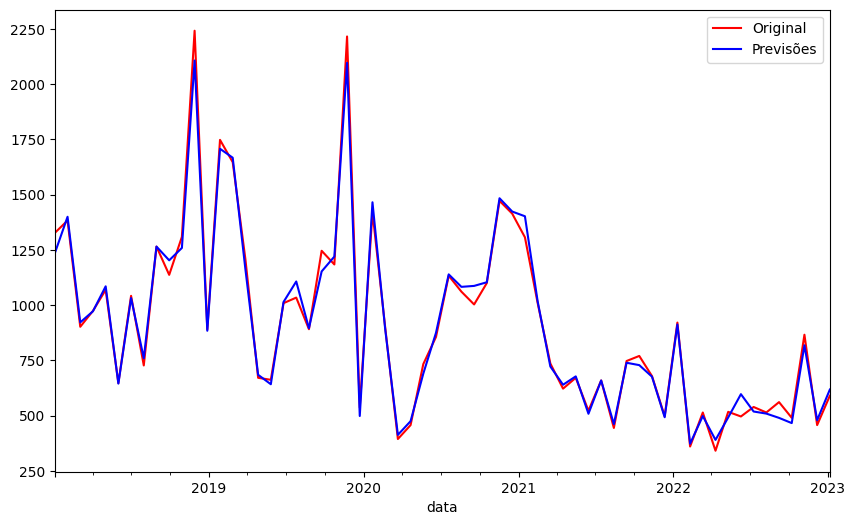


XGBOOST Acurácia Média Treino:  96.39 %.
XGBOOST Erro Médio Absoluto (MAE) Treino:  30.704032258064533
XGBOOST Erro Quadrático Médio (MSE) Treino:  1925.443508064517
XGBOOST Raiz do Erro Quadrático Médio (RMSE) Treino:  1925.443508064517
XGBOOST Porcentagem do Erro Médio Absoluto (MAPE) Treino:  3.61 %
XGBOOST Explained Variance Score Treino:  0.9888322810650242
XGBOOST Erro Máximo Treino:  134.80000000000018
XGBOOST Erro Logarítmico Médio Treino:  0.002493646888660177
XGBOOST Mediana do Erro Absoluto Treino:  18.725000000000023


In [189]:
from sklearn.metrics import r2_score
# Validando os resultados
prediction_xgb_train = best_rf_random.predict(X_train)
plot_predictions(X_train, y_train, prediction_xgb_train)
evaluate_model(y_train, prediction_xgb_train,'Treino')

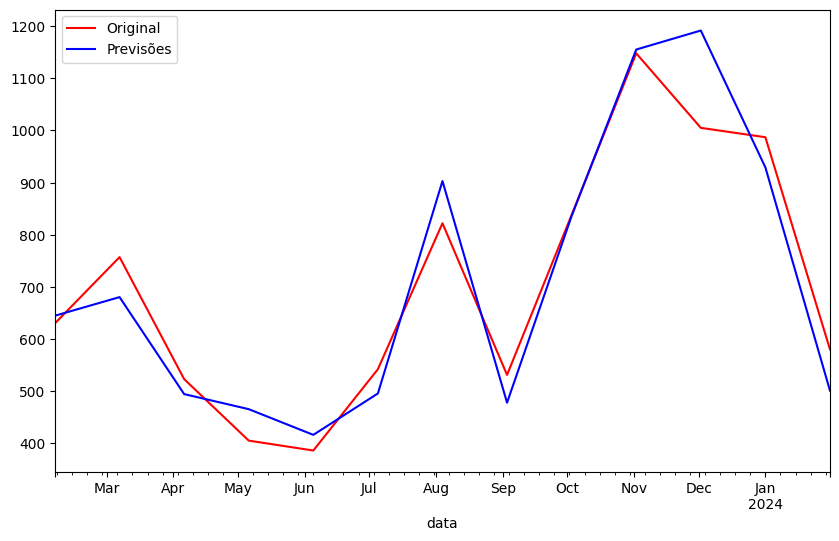


XGBOOST Acurácia Média Teste:  91.69 %.
XGBOOST Erro Médio Absoluto (MAE) Teste:  55.70000000000001
XGBOOST Erro Quadrático Médio (MSE) Teste:  5194.574230769233
XGBOOST Raiz do Erro Quadrático Médio (RMSE) Teste:  5194.574230769233
XGBOOST Porcentagem do Erro Médio Absoluto (MAPE) Teste:  8.31 %
XGBOOST Explained Variance Score Teste:  0.9040551257156003
XGBOOST Erro Máximo Teste:  186.70000000000005
XGBOOST Erro Logarítmico Médio Teste:  0.009376560338124318
XGBOOST Mediana do Erro Absoluto Teste:  53.25


In [190]:
# Validando os resultados
prediction_xgb_test = best_rf_random.predict(X_test)
plot_predictions(X_test, y_test, prediction_xgb_test)
evaluate_model(y_test, prediction_xgb_test,'Teste')

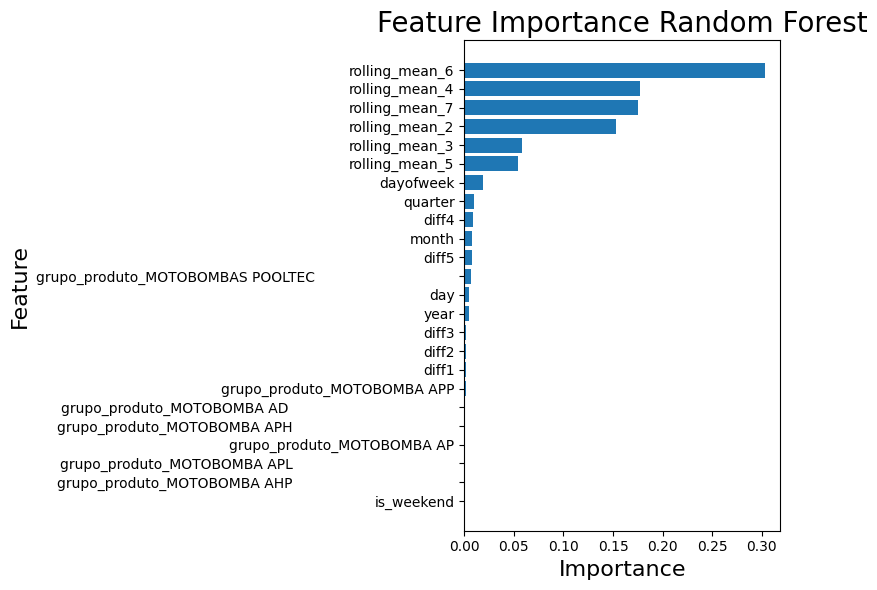

In [191]:
feature_names = list(X_test.columns)  # Your feature names
plot_feature_importance(best_rf_random, feature_names, model_name='Random Forest')
plt.show()

### Iterative Approach to Model the Amount of Items sold in a Time Window

[630.0, 757.0, 523.0, 405.0, 386.0, 542.0, 822.0, 531.0, 838.0, 1148.0]
pred [567.62]
[630.0, 757.0, 523.0, 405.0, 386.0, 542.0, 822.0, 531.0, 838.0, 1148.0, 567.62]
pred [693.83]
[630.0, 757.0, 523.0, 405.0, 386.0, 542.0, 822.0, 531.0, 838.0, 1148.0, 567.62, 693.83]
pred [987.7]
Métricas com previsões normais:
MSE: 4773.8006
MAE: 53.4269

Métricas com previsões iterativas:
MSE: 34113.0156
MAE: 87.5577


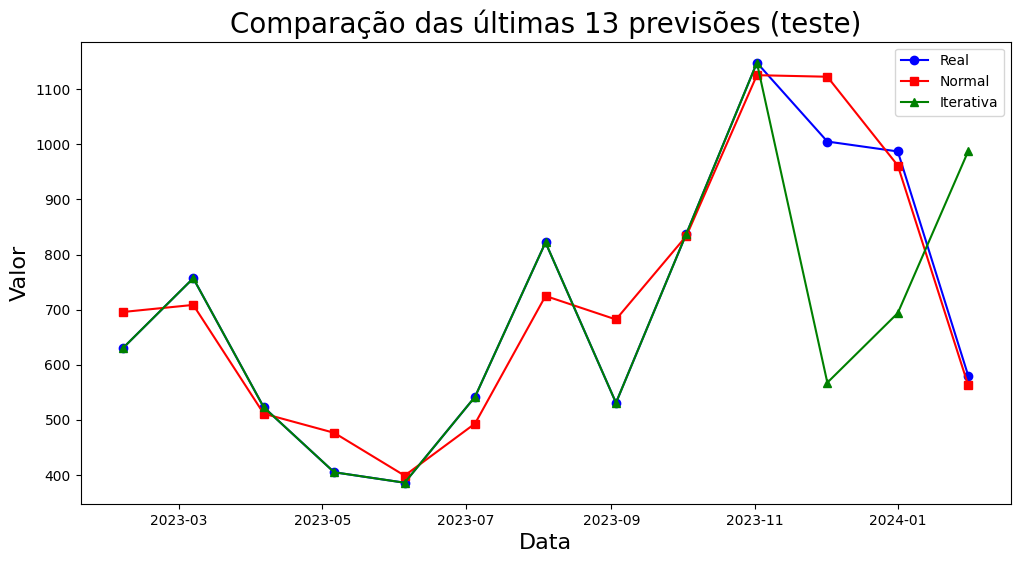

In [192]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def create_features(data, n_lags=3, n_ma=2, n_diff=1):
    """
    Cria features de lag, média móvel e diferenciação para uma série temporal.

    Args:
        data: Array ou Series com os dados
        n_lags: Número de lags
        n_ma: Número de períodos para média móvel
        n_diff: Número de diferenciações

    Returns:
        DataFrame com as features e lista com os nomes das features
    """

    # Adicionar lags
    for i in range(1, n_lags + 1):
        data[f'qt_item_lag_{i}'] = data['qt_item'].shift(i)

    # Adicionar médias móveis
    for i in range(2, n_ma + 2):  # começa do 2 pois média móvel de 1 é o próprio valor
        data[f'qt_item_ma_{i}'] = data['qt_item'].shift(1).rolling(window=i).mean()

    # Adicionar diferenciações
    for i in range(1, n_diff + 1):
        data[f'qt_item_diff_{i}'] = data['qt_item'].shift(1).diff(i)

    return data

def make_iterative_predictions_with_features(model, X_test, n_lags=3, n_ma=2, n_diff=1):
    """
    Faz previsões iterativas usando lags, médias móveis e diferenciações.

    Args:
        model: Modelo treinado
        X_test: Conjunto de teste
        n_lags: Número de lags
        n_ma: Número de períodos para média móvel
        n_diff: Número de diferenciações

    Returns:
        Array com as previsões
    """
    # Converter X_test para DataFrame se não for
    if isinstance(X_test, np.ndarray):
        X_test = pd.DataFrame(X_test)

    # Criar série temporal com os valores iniciais (últimos valores conhecidos)
    #history = pd.Data(X_test.iloc[:, 0].values)  # assume primeira coluna como valor atual
#    predictions = []
    predictions = [y_test[i] for i in range(10)]
    # Fazer previsões iterativas
    for i in range(10,len(X_test)):

        # Pegar última linha de features (ponto atual)
        current_features = X_test[:i]
        print(predictions)
#        predictions2 = predictions.shift(-1)
        current_features['qt_item'] = predictions
        current_features['qt_item'] = current_features['qt_item'].shift(1)

        # Criar features para o ponto atual
        current_features = create_features(current_features, n_lags, n_ma, n_diff)

        # Preencher valores ausentes (NaN) com 0
#        current_features = current_features.fillna(0)
        current_features = current_features.dropna()

#        print(current_features.iloc[-1])
#        print(X_test.iloc[-1])
        # Fazer previsão
        current_features.drop(columns=['qt_item'],inplace=True)
        pred = model.predict(current_features.values[-1].reshape(1, -1))
        predictions.append(pred[0])
        print('pred',pred)

        # Adicionar previsão ao histórico para próxima iteração
        if i < len(X_test) - 1:
            #history.iloc[-1] = pred
            #history = pd.concat([history, pd.Series([0])])  # adicionar próximo ponto
            #history = current_features
            #history['qt_item'] = predictions
            pass


    return np.array(predictions)

# Exemplo de uso
if __name__ == "__main__":
    df_sales = df_prods_final_ML.copy()
    df_sales = create_features(df_sales, n_lags=6, n_ma=6, n_diff=5)
    df_sales.set_index('data',inplace=True)
    # ordenando e tirando features categóricos irrelevantes
    df_sales = df_sales.drop(['cod_produto','produto'], axis = 1).sort_values(by=['grupo_produto','data'])
    # OHE em grupo produto
    df_sales = pd.get_dummies(df_sales, columns=['grupo_produto'])
    df_sales.dropna(inplace=True)
    if ADVANCE_RESAMPLE_DAYS > 0:
      df_sales['qt_item'] = df_sales['qt_item'].shift(-ADVANCE_RESAMPLE_DAYS)
      print('aq')
    else:
      pass

    # reamostrando pelo número de dias escolhido
    df_sales = df_sales.resample(f'{RESAMPLE_DAYS}D').sum()

    #Separação do conjunto entre treinamento e teste
    train_size = int(len(df_sales) * TRAIN_SIZE)
    train_data, test_data = df_sales[:train_size], df_sales[train_size:]

    X_train = train_data.drop(columns=['qt_item'])
    y_train = train_data["qt_item"]

    X_test = test_data.drop(columns=['qt_item'])
    y_test = test_data["qt_item"]

    # feature que não serve pra nada, vamos retirar
    X_train.drop(columns=['week_of_year'],inplace=True)
    X_test.drop(columns=['week_of_year'],inplace=True)


    # Treinar modelo
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Fazer previsões normais
    normal_preds = model.predict(X_test)

    # Fazer previsões iterativas
    iterative_preds = make_iterative_predictions_with_features(
        model,
        X_test,
        n_lags=6,
        n_ma=6,
        n_diff=5
    )

    # Comparar resultados
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    print("Métricas com previsões normais:")
    print(f"MSE: {mean_squared_error(y_test, normal_preds):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, normal_preds):.4f}")

    print("\nMétricas com previsões iterativas:")
    print(f"MSE: {mean_squared_error(y_test, iterative_preds):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, iterative_preds):.4f}")


    # Criar visualização
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Real', marker='o',color='blue')
    plt.plot(y_test.index, normal_preds, label='Normal', marker='s',color='red')
    plt.plot(y_test.index, iterative_preds, label='Iterativa', marker='^',color='green')
    plt.legend()
    plt.title(f'Comparação das últimas {len(y_test)} previsões (teste)',size=20)
    plt.xlabel('Data',size=16)
    plt.ylabel('Valor',size=16)
    plt.show()